**Disclaimer:**  The content in these Jupyter Notebooks is aggregated from various online sources dedicated to the documentation of the tools we will be using. Accuracy and completeness are not guaranteed. Use at your own risk and verify critical information independently.

# Intro to Semantic Kernel

Since the release of ChatGPT, Large language models (LLMs) have received a huge amount of attention in both industry and the media; resulting in an unprecedented demand to try and leverage LLMs in almost every conceivable context.

Semantic Kernel is an open-source SDK originally developed by Microsoft to power products such as Microsoft 365 Copilot and Bing, designed to make it easy to integrate LLMs into applications. It enables users to leverage LLMs to orchestrate workflows based on natural language queries and commands by making it possible to connect these models with external services that provide additional functionality the model can use to complete tasks.

As it was created with the Microsoft ecosystem in mind, many of the complex examples currently available are written in C#, with fewer resources focusing on the Python SDK. In this blog post, we shall demonstrate how to get started with the Semantic Kernel using Python, introducing the key components and exploring how these can be used to perform various tasks.

**Important Note**:  Semantic Kernel, like everything related to related to LLMs, is moving incredibly fast. As such, interfaces may change slightly over time; we will try to keep this post updated where we can. Whilst we work for Microsoft, we am not asked to, or compensated for, promoting Semantic Kernel in any way. 

The packages used were:

dependencies:
  - python=3.10.1.0
  - pip:
    - semantic-kernel==0.3.12.dev
    - timm==0.9.5
    - transformers==4.32.0
    - sentence-transformers==2.2.2
    - curated-transformers==1.1.0

Let's begin with the central component of the library.

### The Kernel
`Kernel`: "The core, center, or essence of an object or system." — Wiktionary

One of the key concepts in Semantic Kernel is the kernel itself, which is the main object that we will use to orchestrate our LLM based workflows. Initially, the kernel has very limited functionality; all of its features are largely powered by external components that we will connect to. The kernel then acts as a processing engine that fulfils a request by invoking appropriate components to complete the given task.

We can create a kernel as demonstrated below:

In [1]:
import semantic_kernel as sk
import os
import openai
from dotenv import load_dotenv
# Load environment variables
load_dotenv()

# Configure OpenAI API
OPENAI_API_TYPE = "azure"
OPENAI_API_ENDPOINT= os.getenv('OPENAI_API_BASE')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
OPENAI_API_VERSION = os.getenv('OPENAI_API_VERSION')
OPENAI_DEPLOYMENT_NAME = "gpt-35-turbo-16k"
print("Open AI version:", openai.__version__)

kernel = sk.Kernel()

Open AI version: 0.27.9


### Connectors
To make our kernel useful, we need to connect one or more AI models, which enable us to use our kernel to understand and generate natural language; this is done using a connector. Semantic Kernel provides out-of-the-box connectors that make it easy to add AI models from different sources, such as OpenAI, Azure OpenAI, and Hugging Face. These models are then used to provide a service to the kernel.

At the time of writing, the following services are supported:

text completion service: used to generate natural language
chat service: used to create a conversational experience
text embedding generation service: used to encode natural language into embeddings
Each type of service can support multiple models from different sources at the same time, making it possible to switch between different models, depending on the task and the preference of the user. If no specific service or model is specified, the kernel will default to the first service and model that was defined.

We can see all of the currently registered services using the following methods:

In [2]:
def print_ai_services(kernel):
    print(f"Text completion services: {kernel.all_text_completion_services()}")
    print(f"Chat completion services: {kernel.all_chat_services()}")
    print(
        f"Text embedding generation services: {kernel.all_text_embedding_generation_services()}"
    )

In [3]:
print_ai_services(kernel)

Text completion services: []
Chat completion services: []
Text embedding generation services: []


As expected, we don't currently have any connected services! Let's change that.
Here, I will start by accessing a `gpt-35-turbo-16k` model which I deployed using the Azure OpenAI service in my Azure subscription.
As this model can be used for both text completion and chat, I will register using both services.

In [3]:
from semantic_kernel.connectors.ai.open_ai import (
    AzureChatCompletion,
    OpenAITextEmbedding,
)
kernel.add_text_embedding_generation_service(
            "openai-embedding",
            OpenAITextEmbedding(
                model_id= "text-embedding-ada-002",
                api_key=OPENAI_API_KEY,
                endpoint=OPENAI_API_ENDPOINT,
                api_type=OPENAI_API_TYPE,
                api_version=OPENAI_API_VERSION,
            ),
)


gpt35_chat_service = AzureChatCompletion(
    deployment_name=OPENAI_DEPLOYMENT_NAME,
    endpoint=OPENAI_API_ENDPOINT,
    api_key=OPENAI_API_KEY,
)

kernel.add_chat_service("azure_gpt35_chat_completion", gpt35_chat_service)


We can see that the chat service has been registered as both a text completion and a chat completion service.

In [5]:
print_ai_services(kernel)

Text completion services: ['azure_gpt35_chat_completion']
Chat completion services: ['azure_gpt35_chat_completion']
Text embedding generation services: ['openai-embedding']


### Semantic functions

The way to interact with a LLM through Semantic Kernel is to create a Semantic Function. A semantic function expects a natural language input and uses an LLM to interpret what is being asked, then act accordingly to return an appropriate response. For example, a semantic function could be used for tasks such as text generation, summarization, sentiment analysis, and question answering.

In Semantic Kernel, a semantic function is composed of two components:

**Prompt Template**: the natural language query or command that will be sent to the LLM

**Configuration object:** contains the settings and options for the semantic function, such as the service that it should use, the parameters it should expect, and the description of what the function does.

The simplest way to get started is by using the kernel's `create_semantic_function` method, which accepts fixed arguments such as `temperature` and `max_tokens` which are usually required by LLMs and uses these to build a config for us.

To illustrate this, let's create a simple prompt:

In [6]:
prompt = """
{{$input}} is the capital city of
"""

generate_capital_city_text = kernel.create_semantic_function(
    prompt, max_tokens=100, temperature=0, top_p=0
)

Here, we have used the `{{$}}` syntax to represent an argument that will be injected into our prompt. Whilst we shall see many more examples of this throughout this post, a comprehensive guide to templating syntax can be found in the documentation.

We can inspect some details about our semantic function as demonstrated below:

In [7]:
generate_capital_city_text.describe()

FunctionView(name='f_5b8f9424_b441_431a_9e20_1b494d6437c7', skill_name='_GLOBAL_FUNCTIONS_', description='Generic function, unknown purpose', is_semantic=True, parameters=[ParameterView(name='input', description='', default_value='')], is_asynchronous=True)

Here, we can see that it is been given a generic description, as we did not provide this.

Now, we can use our function simply by calling it:

In [8]:
response = generate_capital_city_text("Paris")

Alternatively, most of the kernel methods support async invocation using [Asyncio](https://docs.python.org/3/library/asyncio.html). As many of our connected services are likely to be calling external APIs, invoking asynchronously should provide a performance boost when using a semantic function in an application running on an event loop.
We can do this as follows.

In [9]:
response = await generate_capital_city_text.invoke_async("Paris")

The response object contains valuable information about our function call, such as whether an error occurred and what that was; provided everything worked as expected, we can access our result using `response.result`

In [10]:
response.result

'France.'

If we print our response, the result is accessed for us.

In [11]:
print(response)

France.


Here, we can see that our function has worked!
One thing to watch out for is silent failures. The way semantic kernel works is by passing a context object between functions which is constantly updated.

In [12]:
type(response)

semantic_kernel.orchestration.sk_context.SKContext

This means that, if we have a single function and this fails, sometimes the input is returned. We can demonstrate this by setting a parameter incorrectly.

In [13]:
generate_capital_city_text_error = kernel.create_semantic_function(
    prompt, max_tokens=100, temperature="incorrect_param", top_p=0
)
error_response = generate_capital_city_text_error("Paris")

In [14]:
error_response.result

'Paris'

Here, we can explicitly check for an error, as follows.

In [15]:
error_response.error_occurred

True

In [16]:
error_response.last_error_description

'(<ErrorCodes.ServiceError: 6>, \'OpenAI service failed to complete the chat\', InvalidRequestError(message="\'incorrect_param\' is not of type \'number\' - \'temperature\'", param=None, code=None, http_status=400, request_id=None))'

This is clear if we print the response but, without appropriate checks, this can lead to confusing results when accessing results in or applications!

In [17]:
print(error_response)

Error: (<ErrorCodes.ServiceError: 6>, 'OpenAI service failed to complete the chat', InvalidRequestError(message="'incorrect_param' is not of type 'number' - 'temperature'", param=None, code=None, http_status=400, request_id=None))


### Creating a Semantic Function Config

Whilst `create_semantic_function` is useful to get us started, it doesn't expose many of the options that we require for more complex cases; such as specifying the model that we would like to use, or custom arguments that we may require.

To illustrate this, let's register another text completion service, and create a config which enables us to specify that we would like to use our new service. For our second completion service, let's use a model from the Hugging Face transformers library. To do this, we use the `HuggingFaceTextCompletion` connector.

Here, as we will be running the model locally, we haveselected GPT2, an older member of the GPT model family, which should be able to run quickly easily on most hardware.

In [31]:
from semantic_kernel.connectors.ai.hugging_face import HuggingFaceTextCompletion

hf_model = HuggingFaceTextCompletion("gpt2", task="text-generation")
kernel.add_text_completion_service("hf_gpt2_text_completion", hf_model)

Now, let's create our config object. Probabily the easiest way to do this is by creating a dictionary, and loading the config from this; this way, we can save our configuration to a json file if needed.

We can do this using the format below:

In [ ]:
hf_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "Provides information about a capital city, which is given as an input, using the GPT2 model",
    # Specifies which model service(s) to use
    "default_services": ["hf_gpt2_text_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.01,
        "top_p": 1,
        "max_tokens": 256,
        "number_of_responses": 1,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "input",
                "description": "The name of the capital city",
                "defaultValue": "London",
            }
        ]
    },
}

Now, we can load our config directly into a `PromptTemplateConfig` object.

In [34]:
from semantic_kernel import PromptTemplateConfig

prompt_template_config = PromptTemplateConfig.from_dict(hf_config_dict)

Now, we have our prompt config, let's create our prompt. Previously, we did this using a string, but Semantic Kernel provides some template classes to provide more structure around this.

In [35]:
from semantic_kernel import PromptTemplate

prompt_template = sk.PromptTemplate(
    template="{{$input}} is the capital city of",
    prompt_config=prompt_template_config,
    template_engine=kernel.prompt_template_engine,
)

Finally, we can create our semantic function config, which bundles to keep our prompt and it's config in the same object.

In [36]:
from semantic_kernel import SemanticFunctionConfig

function_config = SemanticFunctionConfig(prompt_template_config, prompt_template)

As there are a few steps involved here, let's gather these into a function for convenience.

In [37]:
from semantic_kernel import PromptTemplateConfig, SemanticFunctionConfig, PromptTemplate
def create_semantic_function_config(prompt_template, prompt_config_dict, kernel):
    prompt_template_config = PromptTemplateConfig.from_dict(prompt_config_dict)
    prompt_template = sk.PromptTemplate(
        template=prompt_template,
        prompt_config=prompt_template_config,
        template_engine=kernel.prompt_template_engine,
    )
    return SemanticFunctionConfig(prompt_template_config, prompt_template)

Now, we can register our semantic function, using our defined config, as demonstrated below:

In [38]:
gpt2_complete = kernel.register_semantic_function(
    skill_name="GPT2Complete",
    function_name="gpt2_complete",
    function_config=create_semantic_function_config(
        "{{$input}} is the capital city of", hf_config_dict, kernel
    ),
)

In [39]:
response = gpt2_complete("Paris")

In [40]:
print(response)

Paris is the capital city of the European Union.

The EU's top diplomat, Federica Mogherini, said the EU was "deeply concerned" by the "unacceptable" treatment of migrants in the EU.

"We are deeply concerned by the treatment of migrants in the EU," she said.

"We are also deeply concerned by the fact that the EU is not doing its job and is not doing its job properly.

"We are also deeply concerned by the fact that the EU is not doing its job and is not doing its job properly."

The EU's top diplomat, Federica Mogherini, said the EU was "deeply concerned" by the "unacceptable" treatment of migrants in the EU

"We are also deeply concerned by the fact that the EU is not doing its job and is not doing its job properly."

The EU's top diplomat, Federica Mogherini, said the EU was "deeply concerned" by the "unacceptable" treatment of migrants in the EU

"We are also deeply concerned by the fact that the EU is not doing its job and is not doing its job properly."

The EU's top diplomat, Fed

### Creating a custom connector

Now that we have seen how to create a semantic function and specify which service we would like our function to use. However, until this point, all of the services we have used have relied on out-of-the-box connectors. In some cases, we may wish to use a model from a different library to those currently supported, for which we will need a custom connector. Let's look at how we can do this.

As an example, let's use a transformer model from the [curated transformers](https://github.com/explosion/curated-transformers) library.

To create a custom connector, we need to subclass `TextCompletionClientBase`, which acts as a thin wrapper around our model. A simple example of how to do this is provided below.

In [41]:
from typing import List, Optional, Union

import torch
from curated_transformers.generation import (
    AutoGenerator,
    SampleGeneratorConfig,
)
from semantic_kernel.connectors.ai.ai_exception import AIException
from semantic_kernel.connectors.ai.complete_request_settings import (
    CompleteRequestSettings,
)
from semantic_kernel.connectors.ai.text_completion_client_base import (
    TextCompletionClientBase,
)


class CuratedTransformersCompletion(TextCompletionClientBase):
    def __init__(
        self,
        model_name: str,
        device: Optional[int] = -1,
    ) -> None:
        """
        Use a curated transformer model for text completion.

        Arguments:
            model_name {str}
            device_idx {Optional[int]} -- Device to run the model on, -1 for CPU, 0+ for GPU.

        Note that this model will be downloaded from the Hugging Face model hub.
        """
        self.model_name = model_name
        self.device = (
            "cuda:" + str(device)
            if device >= 0 and torch.cuda.is_available()
            else "cpu"
        )

        self.generator = AutoGenerator.from_hf_hub(
            name=model_name, device=torch.device(self.device)
        )

    async def complete_async(
        self, prompt: str, request_settings: CompleteRequestSettings
    ) -> Union[str, List[str]]:
        generator_config = SampleGeneratorConfig(
            temperature=request_settings.temperature,
            top_p=request_settings.top_p,
        )
        try:
            with torch.no_grad():
                result = self.generator([prompt], generator_config)

            return result[0]

        except Exception as e:
            raise AIException("CuratedTransformer completion failed", e)

    async def complete_stream_async(
        self, prompt: str, request_settings: CompleteRequestSettings
    ):
        raise NotImplementedError(
            "Streaming is not supported for CuratedTransformersCompletion."
        )

Now, we can register our connector and create a semantic function as demonstrated before. Here, we areusing the `Falcon-7B` model, which will require a GPU to run in a reasonable amount of time.

In [42]:
kernel.add_text_completion_service(
    "falcon-7b_text_completion",
    CuratedTransformersCompletion(model_name="tiiuae/falcon-7b", device=0),
)

config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "Provides information about a capital city, which is given as an input, using the Falcon-7B model",
    # Specifies which model service(s) to use
    "default_services": ["falcon-7b_text_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.01,
        "top_p": 1,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "input",
                "description": "The name of the capital city",
                "defaultValue": "London",
            }
        ]
    },
}

falcon_complete = kernel.register_semantic_function(
    skill_name="Falcon7BComplete",
    function_name="falcon7b_complete",
    function_config=create_semantic_function_config(
        "{{$input}} is the capital city of", config_dict, kernel
    ),
)

(…)ae/falcon-7b/resolve/main/tokenizer.json: 100%|██████████| 2.73M/2.73M [00:00<00:00, 5.35MB/s]
c:\Users\hzmarrou\OneDrive\azopenai\azopenai-vbd\vazopenai\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hzmarrou\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
(…)-7b/resolve

In [43]:
print(falcon_complete("Paris"))

France. It is the most populous city in France and the second most populous city in the European Union. It is also the most visited city in the world.
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital city of
Paris is the capital


Once again, we can see that the generation has worked, but it quickly descends into repetition after it has answered our question.

A likely reason for this is the model that we have selected. Commonly, autoregressive transformer models are trained to predict the next word on a large corpus of text; essentially making them powerful autocomplete machines! Here, it appears that it has tried to 'complete' our question, which has resulted in it continuing to generate text, which isn't helpful for us.

### Using a Chat Service
Some LLM models have undergone additional training, to make them more useful to interact with. An example of this process is detailed in [OpenAI's InstructGPT](https://arxiv.org/abs/2203.02155) paper.

At a high level, this usually involves adding one or more supervised finetuning steps where, instead of random unstructured text, the model is trained on curated examples of tasks such as question answering and summarisation; these models are usually known as instruction-tuned or chat models.

As we already observed how base LLMs can generate more text than we need, let's investigate whether a chat model will perform differently. To use our chat model, we need to update our config to specify an appropriate service and create a new function; we shall use `azure_gpt35_chat_completion` in our case.

In [45]:
chat_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "Provides information about a capital city, which is given as an input, using the GPT3.5 model",
    # Specifies which model service(s) to use
    "default_services": ["azure_gpt35_chat_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.0,
        "top_p": 1,
        "max_tokens": 256,
        "number_of_responses": 1,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "input",
                "description": "The name of the capital city",
                "defaultValue": "London",
            }
        ]
    },
}

capital_city_chat = kernel.register_semantic_function(
    skill_name="CapitalCityChat",
    function_name="capital_city_chat",
    function_config=create_semantic_function_config(
        "{{$input}} is the capital city of", chat_config_dict, kernel
    ),
)

In [46]:
response = capital_city_chat("Paris")

In [47]:
response.result

'France.'

Excellent, we can see that the chat model has given us a much more concise answer!

Previously, as we were using text completion models, we had formatted our prompt as a sentence for the model to complete. However, the instruction tuned models should be able to understand a question, so we may be able to change our prompt to make it a little more flexible. Let's see how we can adjust our prompt with the aim of interacting with the model as if it was a chatbot designed to provide us information about places that we may like to visit.

First, let's adjust our function config to make our prompt more generic.

In [48]:
chatbot = kernel.register_semantic_function(
    skill_name="Chatbot",
    function_name="chatbot",
    function_config=create_semantic_function_config(
        "{{$input}}", chat_config_dict, kernel
    ),
)

Here, we can see that we are only passing in the user input, so we must phrase our input as a question. Let's try this.

In [49]:
print(chatbot("Paris is the capital of which country?"))

Paris is the capital of France.


Great, that seems like it has worked. Let's try asking a follow up question.

In [50]:
print(chatbot("What are some interesting things to do there?"))

There are plenty of interesting things to do in New York City. Here are a few suggestions:

1. Visit iconic landmarks: Explore famous landmarks like the Statue of Liberty, Times Square, Central Park, Empire State Building, Brooklyn Bridge, and Rockefeller Center.

2. Museums and art galleries: Discover world-class museums such as the Metropolitan Museum of Art, Museum of Modern Art (MoMA), American Museum of Natural History, Guggenheim Museum, and the Whitney Museum of American Art.

3. Broadway shows: Catch a live performance on Broadway, known for its exceptional theater productions. From musicals to plays, there's something for everyone.

4. Food and culinary experiences: New York City is a food lover's paradise. Try diverse cuisines from around the world in neighborhoods like Chinatown, Little Italy, and Koreatown. Don't forget to grab a slice of New York-style pizza!

5. High Line Park: Walk along the elevated park built on a historic freight rail line. It offers beautiful views o

We can see that the model has provided a very generic answer, which doesn't take into account our previous question at all. This is expected, as the prompt that the model recieved was `"What are some interesting things to do there?"`, we didn't provide any context on where `'there'` is!

Let's see how we can extend our approach to make a simple chatbot in the following section.

#### Making a simple Chatbot
Now that we have seen how we can use a chat service, let's explore how we can create a simple chatbot.

Our chatbot should be able to do three things:

* Know it's purpose and inform us of this

* Understand the current conversation context

* Reply to our questions
Let's adjust our prompt to reflect this.

In [51]:
chatbot_prompt = """
"You are a chatbot to provide information about different cities and countries. 
 For other questions not related to places, you should politely decline to answer the question, stating your purpose"
 +++++

{{$history}}
User: {{$input}}
ChatBot: """

Notice that we have added the variable history which will be used to provide previous context to the chatbot. Whilst this is quite a naive approach, as long conversations will quickly cause the prompt to reach the model's maximum context length, it should work for our purposes.

So far, we have only used prompts which use a single variable. To use multiple variables we need adust our config as demonstrated below.

In [52]:
chat_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "A chatbot to provide information about cities and countries",
    # Specifies which model service(s) to use
    "default_services": ["azure_gpt35_chat_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.0,
        "top_p": 1,
        "max_tokens": 256,
        "number_of_responses": 1,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "input",
                "description": "The input given by the user",
                "defaultValue": "",
            },
            {
                "name": "history",
                "description": "Previous interactions between the user and chatbot",
                "defaultValue": "",
            },
        ]
    },
}

Now, let's use this updated config and prompt to create our chatbot

In [53]:
function_config = create_semantic_function_config(
    chatbot_prompt, chat_config_dict, kernel
)
chatbot = kernel.register_semantic_function(
    skill_name="SimpleChatbot",
    function_name="simple_chatbot",
    function_config=function_config,
)

To pass multiple variables to our semantic function, we need to create a `Context` object, which will store the state of our variables. We can create this, and initialise our history variable, as demonstrated below:

In [54]:
context = kernel.create_new_context()
context["history"] = ""

As input is a special variable, this will be handled automatically. However, is we decided to change the name of this - for example, to `{{$user_input}}` - this would have to be initialised in the same way.

Now, let's create a simple chat function, to update our context after each interaction.

In [55]:
async def chat(input_text, context, verbose=True):
    # Save new message in the context variables
    context["input"] = input_text

    if verbose:
        # print the full prompt before each interaction
        print("Prompt:")
        print("-----")
        # inject the variables into our prompt
        print(await function_config.prompt_template.render_async(context))
        print("-----")

    # Process the user message and get an answer
    answer = await chatbot.invoke_async(context=context)

    # Show the response
    print(f"ChatBot: {answer}")

    # Append the new interaction to the chat history
    context["history"] += f"\nUser: {input_text}\nChatBot: {answer}\n"

Let's try it out!

In [56]:
await chat("Paris is the capital of which country?", context)

Prompt:
-----

"You are a chatbot to provide information about different cities and countries. 
 For other questions not related to places, you should politely decline to answer the question, stating your purpose"
 +++++


User: Paris is the capital of which country?
ChatBot: 
-----
ChatBot: Paris is the capital of France.


In [57]:
await chat("Can you tell me about animals?", context)

Prompt:
-----

"You are a chatbot to provide information about different cities and countries. 
 For other questions not related to places, you should politely decline to answer the question, stating your purpose"
 +++++


User: Paris is the capital of which country?
ChatBot: Paris is the capital of France.

User: Can you tell me about animals?
ChatBot: 
-----
ChatBot: I'm sorry, but I am a chatbot specifically designed to provide information about different cities and countries. I am not able to provide information about animals.


#### Using ChatPromptTemplate
Whilst we have seen how to make a simple chatbot using a standard prompt template, Semantic Kernel provides a ChatPromptTemplate to simplify things; keeping track of previous interactions for us.

Let's use this class to update the function which we used to create our semantic function config.

In [59]:
from semantic_kernel import (
    ChatPromptTemplate,
    SemanticFunctionConfig,
    PromptTemplateConfig,
)


def create_semantic_function_chat_config(prompt_template, prompt_config_dict, kernel):
    chat_system_message = (
        prompt_config_dict.pop("system_prompt")
        if "system_prompt" in prompt_config_dict
        else None
    )

    prompt_template_config = PromptTemplateConfig.from_dict(prompt_config_dict)
    prompt_template_config.completion.token_selection_biases = (
        {}
    )  # required for https://github.com/microsoft/semantic-kernel/issues/2564

    prompt_template = ChatPromptTemplate(
        template=prompt_template,
        prompt_config=prompt_template_config,
        template_engine=kernel.prompt_template_engine,
    )

    if chat_system_message is not None:
        prompt_template.add_system_message(chat_system_message)

    return SemanticFunctionConfig(prompt_template_config, prompt_template)

As we can see, ChatPromptTemplate provides the option to set a system message at the start of our interaction, so that we don't have to include it in our prompt. To keep everything in the same place, let's add our system prompt to our config dict; as this is not included in the defined schema, we should remove this before using our config to create our PromptTemplateConfig.

In [60]:
chat_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "A chatbot which provides information about cities and countries",
    # Specifies which model service(s) to use
    "default_services": ["azure_gpt35_chat_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.0,
        "top_p": 1,
        "max_tokens": 500,
        "number_of_responses": 1,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "input",
                "description": "The input given by the user",
                "defaultValue": "",
            },
        ]
    },
    # Non-schema variable
    "system_prompt": "You are a chatbot to provide information about different cities and countries. For other questions not related to places, you should politely decline to answer the question, stating your purpose",
}


chatbot = kernel.register_semantic_function(
    skill_name="Chatbot",
    function_name="chatbot",
    function_config=create_semantic_function_chat_config(
        "{{$input}}", chat_config_dict, kernel
    ),
)

In [61]:
print(chatbot("Paris is the capital of which country?"))

Paris is the capital of France. How can I assist you further?


In [62]:
print(chatbot("What are some interesting things to do there?"))

Paris offers a wide range of interesting activities and attractions. Here are a few popular ones:

1. Visit the Eiffel Tower: This iconic landmark offers stunning views of the city from its observation decks.

2. Explore the Louvre Museum: Home to thousands of artworks, including the famous Mona Lisa, the Louvre is a must-visit for art enthusiasts.

3. Stroll along the Champs-Élysées: This famous avenue is lined with shops, cafes, and theaters, making it a great place for shopping and people-watching.

4. Discover Notre-Dame Cathedral: This Gothic masterpiece is known for its stunning architecture and historical significance.

5. Take a boat cruise on the Seine River: Enjoy a leisurely cruise along the Seine River, passing by famous landmarks and enjoying the city's beautiful scenery.

6. Visit Montmartre: This bohemian neighborhood is known for its artistic history, charming streets, and the iconic Sacré-Cœur Basilica.

7. Explore the Palace of Versailles: Located just outside of Pari

In [63]:
print(chatbot("Can you tell me about animals?"))

I apologize, but as a chatbot specializing in providing information about cities and countries, I am not equipped to provide detailed information about animals. However, there are many resources available online or at your local library that can provide you with extensive information about various animal species. If you have any questions about cities or countries, I'll be happy to assist you.


Here, we can see that we have obtained the same results as from our manual chatbot earlier, with less boilerplate code.

### Memory
When interacting with our chatbot, one of the key aspects that made the experience feel like a useful interaction was that the chatbot was able to retain the context of our previous questions. We did this by giving the chatbot access to memory, leveraging ChatPromptTemplate to handle this for us.

Whilst this worked well enough for our simple use case, all of our conversation history was stored in our system's RAM and not persisted anywhere; once we shut down our system, this is gone forever. For more intelligent applications, it can be useful to be able to build and persist both short and long term memory for our models to access.

Additionally, in our example, we were feeding all of our previous interactions into our prompt. As models usually have a fixed size context window - which determines how long our prompts can be - this will quickly break down if we start to have lengthy conversations. One way to avoid this is to store our memory as separate 'chunks' and only load information that we think may be relevant into our prompt.

Semantic Kernel offers some functionality around how we can incorporate memory into our applications, so let's explore how we can leverage these.

As an example, let's extend our chatbot so that it has access to some information that is stored in memory.

First, we need some information that may be relevant to our chatbot. Whilst we could manually resarch and curate relevant information, it is quicker to have the model generate some for us! Let's get the model to generate some facts about the city of London. We can do this as follows.

In [64]:
response = chatbot(
    """Please provide a comprehensive overview of things to do in London. Structure your answer in 5 paragraphs, based on:
- overview
- landmarks
- history
- culture
- food

Each paragraph should be 100 tokens, do not add titles such as `Overview:` or `Food:` to the paragraphs in your response.

Do not acknowledge the question, with a statement like "Certainly, here's a comprehensive overview of things to do in London". 
Do not provide a closing comment.
"""
)

In [65]:
london_info = response.result
print(london_info)

London, the vibrant capital of England, offers a plethora of activities and attractions for visitors to enjoy. With its rich history, iconic landmarks, diverse culture, and delicious food scene, there is something for everyone in this bustling metropolis.

London is renowned for its landmarks that showcase its historical and architectural significance. The majestic Tower of London, with its medieval fortress and crown jewels, is a must-visit. The iconic Big Ben and the Houses of Parliament are other notable landmarks that dominate the city's skyline. The magnificent Buckingham Palace, the official residence of the British monarch, is a sight to behold, especially during the Changing of the Guard ceremony.

Steeped in history, London has a fascinating past that can be explored through its numerous museums and historical sites. The British Museum houses a vast collection of artifacts from around the world, including the Rosetta Stone. The Tower Bridge Exhibition offers insights into the 

Now that we have some text, so that the model can access only the parts that it needs, let's divide this into chunks. Semantic kernel offers some functionality to do this in it's `text_chunker` module. We can use this as demonstrated below:

In [66]:
from semantic_kernel.text import text_chunker as tc

chunks = tc.split_plaintext_paragraph([london_info], max_tokens=100)

In [67]:
len(chunks)

11

In [68]:
chunks[7]

"London's food scene is a melting pot of flavors from around the world. From traditional English pubs serving fish and chips to Michelin-starred restaurants offering fine dining experiences, there is something to satisfy every palate."

We can see that the text has been split into 11 chunks. Depending on the text, we will have to adjust the maximum number of tokens specified for each chunk.

### Using a Text Embedding Service
Now that we have chunked our data, we need to create a representation of each chunk that enables us to calculate relevance between text; we can do this by representing our text as embeddings.

To generate embeddings, we need to add a text embedding service to our kernel. Similarly to before, there are various connectors that can be used, depending on the source of the underlying model.

First, let's use a text-embedding-ada-002 model deployed in the Azure OpenAI service. This model was trained by OpenAI, and more information about this model can be found in their launch blog post.

In [69]:
OPENAI_EMBEDDING_DEPLOYMENT = "text-embedding-ada-002"

In [70]:
from semantic_kernel.connectors.ai.open_ai import AzureTextEmbedding

kernel.add_text_embedding_generation_service(
    "azure_openai_embedding",
    AzureTextEmbedding(
        deployment_name=OPENAI_EMBEDDING_DEPLOYMENT,
        endpoint=OPENAI_API_ENDPOINT,
        api_key=OPENAI_API_KEY,
    ),
)

Now that we have access to a model that can generate embeddings, we need somewhere to store these. Semantic Kernel provides the concept of a MemoryStore, which is an interface to various persistence providers.

For production systems, we would probably want to use a database for our persistence, to keep things simple for our example, we shall use in-memory storage. To use memory, we need to register a memory store with our kernel.

In [71]:
memory_store = sk.memory.VolatileMemoryStore()
kernel.register_memory_store(memory_store=memory_store)

Whilst we have used an in-memory memory store to keep things simple for our example, we would probably want to use a database for our persistence when building more complex systems. Semantic Kernel offers connectors to popular storage solutions such as `Azure Cognitive Search`, `CosmosDB`, `Redis`, `Postgres` and many others. As memory stores have a common interface, the only change that would be required would be modifying the connector used, which makes it easy to switch between providers.

We can now save information to our memory store as follows.

In [72]:
for i, chunk in enumerate(chunks):
    await kernel.memory.save_information_async(
        collection="London", id="chunk" + str(i), text=chunk
    )

Here, we have created a new collection, to group similar documents.

We can now query this collection in the following way:

In [73]:
results = await kernel.memory.search_async(
    "London", "what food should I eat in London?", limit=2
)

In [74]:
for result in results:
    print(f"Text: {result.text} \nRelevance:{result.relevance}\n")

Text: London's food scene is a melting pot of flavors from around the world. From traditional English pubs serving fish and chips to Michelin-starred restaurants offering fine dining experiences, there is something to satisfy every palate. 
Relevance:0.8774651349493975

Text: Borough Market is a food lover's paradise, offering a wide range of fresh produce, artisanal products, and international cuisines. Brick Lane is famous for its curry houses, while afternoon tea at one of the city's elegant tea rooms is a quintessential British experience. 
Relevance:0.8466691790678276



Looking at the results, we can see that relevant information has been returned; which is reflected by the high relevance scores.

However, this was quite easy, as we have information direcly relating to what we being asked, using very similar language. Let's try a more subtle query.

In [75]:
results = await kernel.memory.search_async(
    "London", "Where can I eat non-british food in London?", limit=2
)

In [76]:
for result in results:
    print(f"Text: {result.text} \nRelevance:{result.relevance}\n")

Text: London's food scene is a melting pot of flavors from around the world. From traditional English pubs serving fish and chips to Michelin-starred restaurants offering fine dining experiences, there is something to satisfy every palate. 
Relevance:0.8737803364226331

Text: Borough Market is a food lover's paradise, offering a wide range of fresh produce, artisanal products, and international cuisines. Brick Lane is famous for its curry houses, while afternoon tea at one of the city's elegant tea rooms is a quintessential British experience. 
Relevance:0.8410622197867179



Here, we can see that we have recieved exactly the same results. However, as our second result explicitly mentions 'food from around the world', I feel that this is a better match. This highlights some of the potential limitations of a semantic search approach.

#### Using an Open Source model
Out of interest, let's see how an open source model compares with our OpenAI service in this context. We can register a Hugging Face sentence transformer model for this purpose, as demonstrated below:

In [77]:
from semantic_kernel.connectors.ai.hugging_face import HuggingFaceTextEmbedding

hf_embedding_service = HuggingFaceTextEmbedding(
    "sentence-transformers/all-MiniLM-L6-v2", device=-1
)
kernel.add_text_embedding_generation_service(
    "hf_embedding_service",
    hf_embedding_service,
)

(…)f3d3c277d6e90027e55de9125/.gitattributes: 100%|██████████| 1.18k/1.18k [00:00<00:00, 1.18MB/s]
(…)7d6e90027e55de9125/1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 208kB/s]
(…)e2f80f3d3c277d6e90027e55de9125/README.md: 100%|██████████| 10.6k/10.6k [00:00<00:00, 10.6MB/s]
(…)de9125/config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<?, ?B/s] 
(…)d3c277d6e90027e55de9125/data_config.json: 100%|██████████| 39.3k/39.3k [00:00<00:00, 75.8MB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:06<00:00, 14.0MB/s]
(…)90027e55de9125/sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<?, ?B/s]
(…)6e90027e55de9125/special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 111kB/s]
(…)f3d3c277d6e90027e55de9125/tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 4.50MB/s]
(…)7d6e90027e55de9125/tokenizer_config.json: 100%|██████████| 350/350 [00:00<00:00, 337kB/s]
(…)3d3c277d6e90027e55de9125/train_script.py: 100%|██████████| 13.2k/13.2k [00:00<00:

To switch our memory store, we can use the following method.

In [79]:
kernel.use_memory(storage=memory_store, embeddings_generator=hf_embedding_service)

The use_memory method is a convenience method, equivalent to calling kernel.register_memory(SemanticTextMemory(storage, embeddings_generator)). SemanticTextMemory contains the logic for generating the embeddings and managing their storage.

We can now query these in the same way as before.

In [80]:
for i, chunk in enumerate(chunks):
    await kernel.memory.save_information_async(
        "hf_London", id="chunk" + str(i), text=chunk
    )

hf_results = await kernel.memory.search_async(
    "hf_London", "what food should I eat in London", limit=2, min_relevance_score=0
)

In [81]:
for result in hf_results:
    print(f"Text: {result.text} \nRelevance:{result.relevance}\n")

Text: London's food scene is a melting pot of flavors from around the world. From traditional English pubs serving fish and chips to Michelin-starred restaurants offering fine dining experiences, there is something to satisfy every palate. 
Relevance:0.6343544301813628

Text: In conclusion, London is a city that seamlessly blends history, culture, and culinary delights. With its iconic landmarks, fascinating history, diverse culture, and mouthwatering food, it offers a truly unforgettable experience for visitors. 
Relevance:0.6235306756533571



In [82]:
hf_results = await kernel.memory.search_async(
    "hf_London",
    "Where can I eat non-british food in London?",
    limit=2,
    min_relevance_score=0,
)

In [83]:
for result in hf_results:
    print(f"Text: {result.text} \nRelevance:{result.relevance}\n")

Text: London's food scene is a melting pot of flavors from around the world. From traditional English pubs serving fish and chips to Michelin-starred restaurants offering fine dining experiences, there is something to satisfy every palate. 
Relevance:0.6461577865747375

Text: In conclusion, London is a city that seamlessly blends history, culture, and culinary delights. With its iconic landmarks, fascinating history, diverse culture, and mouthwatering food, it offers a truly unforgettable experience for visitors. 
Relevance:0.5838096152242376



We can see that we have returned the same chunks, but our relevance scores are different. We can also observe the difference in the dimensions of the embeddings generated by the different models.

In [84]:
print(
    f"OpenAI embedding size: {results[0].embedding.shape}, Hugging Face embedding size: {hf_results[0].embedding.shape}"
)

OpenAI embedding size: (1536,), Hugging Face embedding size: (384,)


### Integrating memory into context
In our previous example, we saw that whilst we could identify broadly relevant information based on an embedding search, for more subtle queries we didn't receive the most relevant result. Let's explore whether we can improve upon this.

One way that we could approach this is to provide the relevant information to our chatbot, and then let the model decide which parts are the most relevant. Once again, let's define a suitable config for this.

In [85]:
chat_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "A chatbot which provides information about cities and countries",
    # Specifies which model service(s) to use
    "default_services": ["azure_gpt35_chat_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.0,
        "top_p": 1,
        "max_tokens": 500,
        "number_of_responses": 1,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "question",
                "description": "The question given by the user",
                "defaultValue": "",
            },
            {
                "name": "context",
                "description": "Context containing information to be used to help answer the question",
                "defaultValue": "",
            },
        ]
    },
    # Non-schema variable
    "system_prompt": "You are a chatbot to provide information about different cities and countries. ",
}

Next, let's create a prompt which instructs the model to answer the question based on the context provided, and register a semantic function.

In [86]:
prompt_with_context = """
 Use the following pieces of context to answer the users question.
 This is the only information that you should use to answer the question, do not reference information outside of this context.
 If the information required to answer the question is not provided in the context, just say that "I don't know", don't try to make up an answer.
 ----------------
 Context: {{$context}}
 ----------------
 User question: {{$question}}
 ----------------
 Answer:
"""

chatbot_with_context = kernel.register_semantic_function(
    skill_name="ChatbotWithContext",
    function_name="chatbot_with_context",
    function_config=create_semantic_function_chat_config(
        prompt_with_context, chat_config_dict, kernel
    ),
)

Now, we can use this function to answer our more subtle question. First, we create a context object, and add our question to this.

In [87]:
question = "Where can I eat non-british food in London?"

context = kernel.create_new_context()
context["question"] = question

Next, we can manually perform our embedding search, and add the retrieved information to our context.

In [88]:
results = await kernel.memory.search_async("hf_London", question, limit=2)
context["context"] = "\n".join([result.text for result in results])

Finally, we can execute our function. Here, we are using the kernel to execute the function, rather than invoking it directly; this can be useful when we would like to run multiple functions sequentially.

In [89]:
answer = await kernel.run_async(chatbot_with_context, input_vars=context.variables)

In [90]:
print(answer.result)

In London, you can find a wide variety of non-British food options. There are numerous international restaurants and eateries that cater to different cuisines from around the world. Some popular areas for non-British food include Chinatown, which offers a range of Chinese cuisine, and Brick Lane, known for its Indian and Bangladeshi restaurants. Additionally, you can find Italian, Thai, Japanese, Mexican, and many other international cuisines throughout the city.


However, we can also see that our answer contains additional information that was not included in our memory, despite our prompt clearly telling the model not to do this! I also tried adding these instructions to the system prompt, but got the same outcome. Whilst the information is correct in this case, if we weren't familiar with London, we wouldn't be able to validate this; this is a form of hallucination, where the model has 'invented' additional information. This is a good example of how LLMs don't always behave in the way that you expect!

### Plugins
Note: In earlier versions of Semantic Kernel, plugins were known as 'skills'; they were renamed with consistency with Bing and OpenAI. As such, many code references and documentation refer to 'skills'.

A plugin in Semantic Kernel is a group of functions that can be loaded into the kernel to be exposed to AI apps and services. The functions within plugins can then be orchestrated by the kernel to accomplish tasks.

The documentation describes plugins as the "building blocks" of Semantic Kernel, which can be chained together to create complex workflows; as plugins follow the OpenAI plugin specification, plugins created for OpenAI services, Bing, and Microsoft 365 can be used with Semantic Kernel.

Semantic Kernel provides several plugins out-of-the-box, which include:

**ConversationSummarySkill:** To summarize a conversation

**HttpSkill**: To call APIs

**TextMemorySkill**: To store and retrieve text in memory

**TimeSkill**: To acquire the time of day and any other temporal information
Let's start by exploring how we can use a pre-defined plugin, before moving on to investigate how we can create custom plugins.

### Using an out-of-the-box plugin

One of the plugins included in Semantic Kernel is `TextMemorySkill`, which provides functionality to save and recall information from memory. Let's see how we can use this to simplify our previous example of populating our prompt context from memory.

First, we must import our plugin, as demonstrated below.

In [91]:
kernel.import_skill(sk.core_skills.TextMemorySkill())

{'recall': <semantic_kernel.orchestration.sk_function.SKFunction at 0x196af7e1330>,
 'save': <semantic_kernel.orchestration.sk_function.SKFunction at 0x196af7e1690>}

Here, we can see that this plugin contains two semantic functions, `recall` and `save`.

Now, let's modify our prompt:

In [92]:
prompt_with_context_plugin = """
 Use the following pieces of context to answer the users question.
 This is the only information that you should use to answer the question, do not reference information outside of this context.
 If the information required to answer the question is not provided in the context, just say that "I don't know", don't try to make up an answer.
 ----------------
 Context: {{recall $question}}
 ----------------
 User question: {{$question}}
 ----------------
 Answer:
"""

We can see that, to use the `recall` function, we can reference this in our prompt. Now, let's create a config and register a function.

In [93]:
chat_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "A chatbot which provides information about cities and countries",
    # Specifies which model service(s) to use
    "default_services": ["azure_gpt35_chat_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.0,
        "top_p": 1,
        "max_tokens": 500,
        "number_of_responses": 1,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "question",
                "description": "The question given by the user",
                "defaultValue": "",
            },
        ]
    },
    # Non-schema variable
    "system_prompt": "You are a chatbot to provide information about different cities and countries. ",
}


In [ ]:
chatbot_with_context_plugin = kernel.register_semantic_function(
    skill_name="ChatbotWithContextPlugin",
    function_name="chatbot_with_context_plugin",
    function_config=create_semantic_function_chat_config(
        prompt_with_context_plugin, chat_config_dict, kernel
    ),
)

In our manual example, we were able to control aspects such as the number of results returned and the collection to search. When using `TextMemorySkill`, we can set these by adding them to our context. Let's try out our function.

In [94]:
question = "Where can I eat non-british food in London?"

context = kernel.create_new_context()
context["question"] = question
context[sk.core_skills.TextMemorySkill.COLLECTION_PARAM] = "hf_London"
context[sk.core_skills.TextMemorySkill.RELEVANCE_PARAM] = 0.2
context[sk.core_skills.TextMemorySkill.LIMIT_PARAM] = 2

answer = await kernel.run_async(
    chatbot_with_context_plugin, input_vars=context.variables
)

In [95]:
print(answer.result)

In London, you can find a wide variety of non-British food options. The city is known for its diverse culinary scene, offering cuisines from around the world. You can explore different neighborhoods such as Chinatown for Chinese cuisine, Brick Lane for Indian food, Edgware Road for Middle Eastern dishes, and Soho for a range of international cuisines. Additionally, there are many restaurants and food markets that specialize in specific international cuisines, so you can easily find non-British food options throughout the city.


We can see that this is equivalent to our manual approach.

#### Creating Custom Plugins
Now that we understand how to create semantic functions, and how to use plugins, we have everything we need to start making our own plugins!

Plugins can contain two types of functions:

Semantic functions: use natural language to perform actions
Native functions: use Python code to perform actions
which can be combined within a single plugin.

The choice of whether to use a semantic vs native function depends on the task that you are performing. For tasks involving understanding or generating language, semantic functions are the obvious choice. However, for more deterministic tasks, such as performing mathematical operations, downloading data or accessing the time, native functions are better suited.

Let's explore how we can create each type. First, let's create a folder to store our plugins.

In [96]:
from pathlib import Path

plugins_path = Path("Plugins")
plugins_path.mkdir(exist_ok=True)

Creating a Poem generator plugin
For our example, let's create a plugin which generates poems; for this, using a semantic function seems a natural choice. We can create a folder for this plugin in our directory.

In [97]:
poem_gen_plugin_path = plugins_path / "PoemGeneratorPlugin"
poem_gen_plugin_path.mkdir(exist_ok=True)

Recalling that plugins are just a collection of functions, and we are creating a semantic function, the next part should be quite familiar. The key difference is that, instead of defining our prompt and config inline, we will create individual files for these; to make it easier to load.

Let's create a folder for our semantic function, which we shall call `write_poem`.

In [98]:
poem_sc_path = poem_gen_plugin_path / "write_poem"
poem_sc_path.mkdir(exist_ok=True)

Next, we create our prompt, saving it as `skprompt.txt.`

In [99]:
prompt_path = poem_sc_path / "skprompt.txt"

In [100]:
%%writefile {prompt_path}

Please write a poem about {{$input}}

Writing Plugins\PoemGeneratorPlugin\write_poem\skprompt.txt


Now, let's create our config and store this in a json file.

Whilst it is always good practice to set meaningful descriptions in our config, this becomes more important when we are defining plugins; plugins should provide clear descriptions that describe how they behave, what their inputs and outputs are, and what their side effects are. The reason for this is that this is the interface that is presented by our kernel and, if we want to be able to use an LLM to orchestrate tasks, it needs to be able to understand the plugin’s functionality and how to call it so that it can select appropriate functions.

In [101]:
config_path = poem_sc_path / "config.json"

In [102]:
%%writefile {config_path}

{
	"schema": 1,
	"type": "completion",
	"description": "A poem generator, that writes a short poem based on user input",
	"default_services": ["azure_gpt35_chat_completion"],
	"completion": {
		"temperature": 0.0,
		"top_p": 1,
		"max_tokens": 250,
		"number_of_responses": 1,
		"presence_penalty": 0,
		"frequency_penalty": 0
	},
	"input": {
		"parameters": [{
			"name": "input",
			"description": "The topic that the poem should be written about",
			"defaultValue": ""
		}]
	}
}

Writing Plugins\PoemGeneratorPlugin\write_poem\config.json


Note that, as we are saving our config as a JSON file, we need to remove the comments to make this valid JSON.

Now, we are able to import our plugin:

In [103]:
poem_gen_plugin = kernel.import_semantic_skill_from_directory(
    plugins_path, "PoemGeneratorPlugin"
)

Inspecting our plugin, we can see that it exposes our write_poem semantic function.

In [104]:
poem_gen_plugin

{'write_poem': <semantic_kernel.orchestration.sk_function.SKFunction at 0x196af7e0850>}

We can call our semantic function directly

In [105]:
result = poem_gen_plugin["write_poem"]("Munich")

In [106]:
print(result)

In the heart of Bavaria, a city so grand,
Lies Munich, a place where dreams expand.
With its rich history and culture so deep,
A tapestry of stories, for us to keep.

Oh, Munich, where the past and present unite,
A symphony of old and new, shining so bright.
From the ancient walls of Nymphenburg Palace,
To the modern marvels, a futuristic embrace.

The Marienplatz, a bustling square of delight,
Where the Glockenspiel dances, day and night.
The Rathaus stands tall, a symbol of power,
As the city's heartbeat, it ticks every hour.

Stroll through the Englischer Garten's green,
Where tranquility reigns, a peaceful scene.
The Isar River flows, a gentle embrace,
Inviting all to wander, at their own pace.

The Frauenkirche, with its twin towers high,
Guides the faithful, reaching for the sky.
Inside, the whispers of prayers and devotion,
Echo through the halls, a sacred emotion.

Munich, a city of art, where creativity thrives,
The Pinakothek Museums, where beauty arrives.
From Dürer to Kandi

Or, we can use it in another semantic function:

In [ ]:
chat_config_dict = {
    "schema": 1,
    # The type of prompt
    "type": "completion",
    # A description of what the semantic function does
    "description": "Wraps a plugin to write a poem",
    # Specifies which model service(s) to use
    "default_services": ["azure_gpt35_chat_completion"],
    # The parameters that will be passed to the connector and model service
    "completion": {
        "temperature": 0.0,
        "top_p": 1,
        "max_tokens": 500,
        "number_of_responses": 1,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
    # Defines the variables that are used inside of the prompt
    "input": {
        "parameters": [
            {
                "name": "input",
                "description": "The input given by the user",
                "defaultValue": "",
            },
        ]
    },
}

prompt = """
{{PoemGeneratorPlugin.write_poem $input}}
"""

write_poem_wrapper = kernel.register_semantic_function(
    skill_name="PoemWrapper",
    function_name="poem_wrapper",
    function_config=create_semantic_function_chat_config(
        prompt, chat_config_dict, kernel
    ),
)

result = write_poem_wrapper("Munich")
print(result)

In [108]:
print(result)

for the eyes, a captivating sight.

And let us not forget the Oktoberfest,
A celebration of beer, where all are blessed.
The Theresienwiese, filled with laughter and cheer,
As the music plays, and the beer flows near.

But Munich is more than just its famous brew,
It's a city of innovation, where ideas come true.
From BMW to Siemens, a hub of industry,
Where progress and ingenuity set the city free.

So come, explore Munich, with its charm and grace,
A city that welcomes, with a warm embrace.
Immerse yourself in its history and art,
And let Munich's spirit capture your heart.


### Creating an Image Classifier plugin
Now that we have seen how to use a Semantic function in a plugin, let's take a look at how we can use a native function.

Here, let's create a plugin that takes an image url, then downloads and classifies the image. Once again, let's create a folder for our new plugin.

In [109]:
image_classifier_plugin_path = plugins_path / "ImageClassifierPlugin"
image_classifier_plugin_path.mkdir(exist_ok=True)

Now, we can create our Python module. Inside the module, we can be quite flexible. Here, we have created a class with two methods, the key step is to use the sk_function decorator to specify which methods should be exposed as part of the plugin.
In this example, our function only requires a single input. For functions that require multiple inputs, the `sk_function_context_parameter` can be used, as demonstrated in the [documentation](https://learn.microsoft.com/en-us/semantic-kernel/ai-orchestration/native-functions?tabs=python).

In [110]:
download_image_sc_path = image_classifier_plugin_path / "download_image.py"
download_image_sc_path.mkdir(exist_ok=True)

In [111]:
import requests
from PIL import Image
import timm
from timm.data.imagenet_info import ImageNetInfo

from semantic_kernel.skill_definition import (
    sk_function,
)
from semantic_kernel.orchestration.sk_context import SKContext


class ImageClassifierPlugin:
    def __init__(self):
        self.model = timm.create_model("convnext_tiny.in12k_ft_in1k", pretrained=True)
        self.model.eval()
        data_config = timm.data.resolve_model_data_config(self.model)
        self.transforms = timm.data.create_transform(**data_config, is_training=False)
        self.imagenet_info = ImageNetInfo()

    @sk_function(
        description="Takes a url as an input and classifies the image",
        name="classify_image",
        input_description="The url of the image to classify",
    )
    def classify_image(self, url: str) -> str:
        image = self.download_image(url)
        pred = self.model(self.transforms(image)[None])
        return self.imagenet_info.index_to_description(pred.argmax())

    def download_image(self, url):
        return Image.open(requests.get(url, stream=True).raw).convert("RGB")

For this example, we have used the [Pytorch Image Models](https://github.com/huggingface/pytorch-image-models) library to provide our classifier. 
Now, we can simply import our plugin as seen below.

In [112]:
image_classifier = ImageClassifierPlugin()

classify_plugin = kernel.import_skill(image_classifier, skill_name="classify_image")

model.safetensors: 100%|██████████| 114M/114M [00:06<00:00, 18.1MB/s] 


Inspecting our plugin, we can see that only our decorated function is exposed.

In [113]:
classify_plugin.keys()

dict_keys(['classify_image'])

We can verify that our plugin works using an image of a cat from Pixabay.

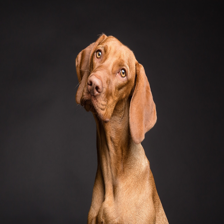

In [122]:
# url = "https://cdn.pixabay.com/photo/2016/02/10/16/37/cat-1192026_1280.jpg"
url = "https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg"
image_classifier.download_image(url).resize((224, 224))

In [123]:
response = classify_plugin["classify_image"](url)

In [124]:
print(response.result)

vizsla, Hungarian pointer


Manually calling our function, we can see that our image has been classified correctly! In the same way as before, we could also reference this function directly from a prompt. However, as we have already demonstrated this, let's try something slightly different in the following section.

In [125]:
response = await classify_plugin["classify_image"].invoke_async(url)
print(response)

vizsla, Hungarian pointer


Chaining multiple plugins
It is also possible to chain multiple plugins together using the kernel, as demonstrated below.

In [126]:
context = kernel.create_new_context()
context["input"] = url

answer = await kernel.run_async(
    classify_plugin["classify_image"],
    poem_gen_plugin["write_poem"],
    input_context=context,
)

In [127]:
print(answer.result)

In the land of Hungary, a breed so grand,
With grace and elegance, they proudly stand.
The Vizsla, a Hungarian pointer so rare,
With a noble spirit, beyond compare.

With a coat of russet, like the autumn leaves,
They roam the fields, like a gentle breeze.
Their eyes, so bright, filled with intelligence,
A loyal companion, with a heart immense.

In the open meadows, they swiftly run,
Their agility and speed, second to none.
A hunter's delight, with a keen sense of smell,
Tracking their prey, as if under a spell.

But beyond their skills in the hunting field,
Their love and devotion, forever sealed.
A family dog, with a gentle demeanor,
They bring joy and love, to all who are near.

Their loyalty knows no bounds, it's true,
Always by your side, through and through.
A friend for life, through thick and thin,
With a Vizsla, love is sure to win.

So let us celebrate this Hungarian breed,
With their regal presence, they indeed succeed.
The Vizsla, a pointer with a heart so pure,
A cherished

### Orchestrating workflows with a Planner

At this point, we have thoroughly explored semantic functions, understand how functions can be grouped and used as part of a plugin, and have seen how we can chain plugins together manually. Now, let's explore how we can create and orchestrate workflows using LLMs. To do this, Semantic Kernel provides `Planner` objects, which can dynamically create chains of functions to try and achieve a goal.

A planner is a class that takes a user prompt and a kernel, and uses the kernel's services to create a plan of how to perform the task, using the functions and plugins that have been made available to the kernel. As the plugins are the main building blocks of these plans, the planner relies heavily on the descriptions provided; if plugins and functions don't have clear descriptions, the planner will not be able to use them correctly. Additionally, as a planner can combine functions in various different ways, it is important to ensure that we only expose functions that we are happy for the planner to use.

As the planner relies on a model to generate a plan, there can be errors introduced; these usually arise when the planner doesn't properly understand how to use the function. In these cases, we havefound that providing explicit instructions - such as describing the inputs and outputs, and stating whether inputs are required - in the descriptions can lead to better results. Additionally, we havehad better results using instruction tuned models than base models; base text completion models tend to hallucinate functions that don't exist or create multiple plans. Despite these limitations, when everything works correctly, planners can be incredibly powerful!

Let's explore how we can do this by exploring if we can create a plan to write a poem about an image, based on its url; using the plugins we created earlier. As we have defined lots of functions that we no longer need, let's create a new kernel, so we can control which functions are exposed.

In [128]:
kernel = sk.Kernel()

To create our plan, let's use our OpenAI chat service.

In [130]:
kernel.add_chat_service(
    service_id="azure_gpt35_chat_completion",
    service=AzureChatCompletion(
        OPENAI_DEPLOYMENT_NAME, OPENAI_API_ENDPOINT, OPENAI_API_KEY
    ),
)

In [131]:
print_ai_services(kernel)

Text completion services: ['azure_gpt35_chat_completion']
Chat completion services: ['azure_gpt35_chat_completion']
Text embedding generation services: []


Inspecting our registered services, we can see that our service can be used for both text completion and chat completion tasks.

Now, let's import our plugins.

In [132]:
classify_plugin = kernel.import_skill(
    ImageClassifierPlugin(), skill_name="classify_image"
)
poem_gen_plugin = kernel.import_semantic_skill_from_directory(
    plugins_path, "PoemGeneratorPlugin"
)

We can see which functions our kernel has access to as demonstrated below.

In [133]:
print(kernel.skills.data.keys())

dict_keys(['classify_image', 'poemgeneratorplugin'])


Now, let's import our planner object.

In [134]:
from semantic_kernel.planning.basic_planner import BasicPlanner

planner = BasicPlanner()

To use our planner, all we need is a prompt. Often, we will need to tweak this depending on the plans that are generated. Here, we have tried to be as explicit as possible about the input that is required.

In [135]:
ask = f"""
I would like you to write poem about what is contained in this image with this url: {url}. This url should be used as input.

"""

Next, we can use our planner to create a plan for how it will solve the task.

In [136]:
plan = await planner.create_plan_async(ask, kernel)

In [137]:
print(plan.generated_plan)

{
    "input": "https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
    "subtasks": [
        {"function": "classify_image.classify_image"},
        {"function": "PoemGeneratorPlugin.write_poem"}
    ]
}


Inspecting our plan, we can see that the model has correctly identified out input, and the correct functions to use!
Finally, all that is left to do is to execute our plan.

In [138]:
poem = await planner.execute_plan_async(plan, kernel)

In [139]:
print(poem)

In the land of Hungary, a breed so grand,
With grace and elegance, they proudly stand.
The Vizsla, a Hungarian pointer so rare,
With a noble spirit, beyond compare.

With a coat of russet, like the autumn leaves,
They roam the fields, like a gentle breeze.
Their eyes, so bright, filled with intelligence,
A loyal companion, with a heart immense.

In the open meadows, they swiftly run,
Their agility and speed, second to none.
With every stride, they exude pure grace,
A sight to behold, in every open space.

Their nose, so keen, can detect a scent,
Guiding hunters, with a purposeful intent.
They point with precision, a bird in flight,
A testament to their instinctive might.

But beyond their skills, in the hunting field,
The Vizsla's true nature is gently revealed.
A loving and gentle soul, they possess,
A loyal friend, in times of happiness.

With their family, they form a bond so deep,
A companion, in both waking and sleep.
Their affection, like a warm embrace,
Filling our hearts, with 

Wow, it worked! For a model trained to predict the next word, that is pretty powerful!

As a word of warning, I was quite lucky when making this example that the generated plan worked first time. However, running this multiple times with the same prompt, we can see that this is not always the case, so it is important to double check your plan before running it! For me personally, in a production system, I would feel much more comfortable manually creating the workflow to execute, rather than leaving it to the LLM! As the technology continues to improve, especially at the current rate, hopefully this recommendation will become outdated!

In [140]:
for i in range(5):
    print((await planner.create_plan_async(ask, kernel)).generated_plan)

{
    "input": "https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
    "subtasks": [
        {"function": "classify_image.classify_image"},
        {"function": "PoemGeneratorPlugin.write_poem"}
    ]
}
{
    "input": "https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
    "subtasks": [
        {"function": "classify_image.classify_image"},
        {"function": "PoemGeneratorPlugin.write_poem"}
    ]
}
{
    "input": "https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
    "subtasks": [
        {"function": "classify_image.classify_image"},
        {"function": "PoemGeneratorPlugin.write_poem"}
    ]
}
{
    "input": "https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
    "subtasks": [
        {"function": "PoemGeneratorPlugin.write_poem"}
    ]
}
{
    "input": "https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
    "subtasks": [
        {"function": "PoemGeneratorPlugin.write_poem"}
    ]
}


### Conclusion
Hopefully that has provided a good introduction to Semantic Kernel and has inspired you to explore using it for your own use cases.
